# RandomForest Model

### Import các thư viện cần thiết

In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler
from colorama import Fore
from sklearn import metrics
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA 
import math
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
# Set random seed for reproducibility
RANDOM_STATE = 0

# Tải dữ liệu và chia dữ liệu thành các tập huấn luyện, đánh giá và kiểm thử

In [3]:
# Load data
data = pd.read_csv('../clean_data/BigDS_train.csv')

# Separate features and target
X = data.drop(columns=['Price'])
y = data['Price']

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

# Reset indices
for df in (X_train, X_val, y_train, y_val):
    df.reset_index(drop=True, inplace=True)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


testset = pd.read_csv('../clean_data/BigDS_test.csv')
X_test = testset.drop('Price', axis = 1)
y_test = testset['Price']

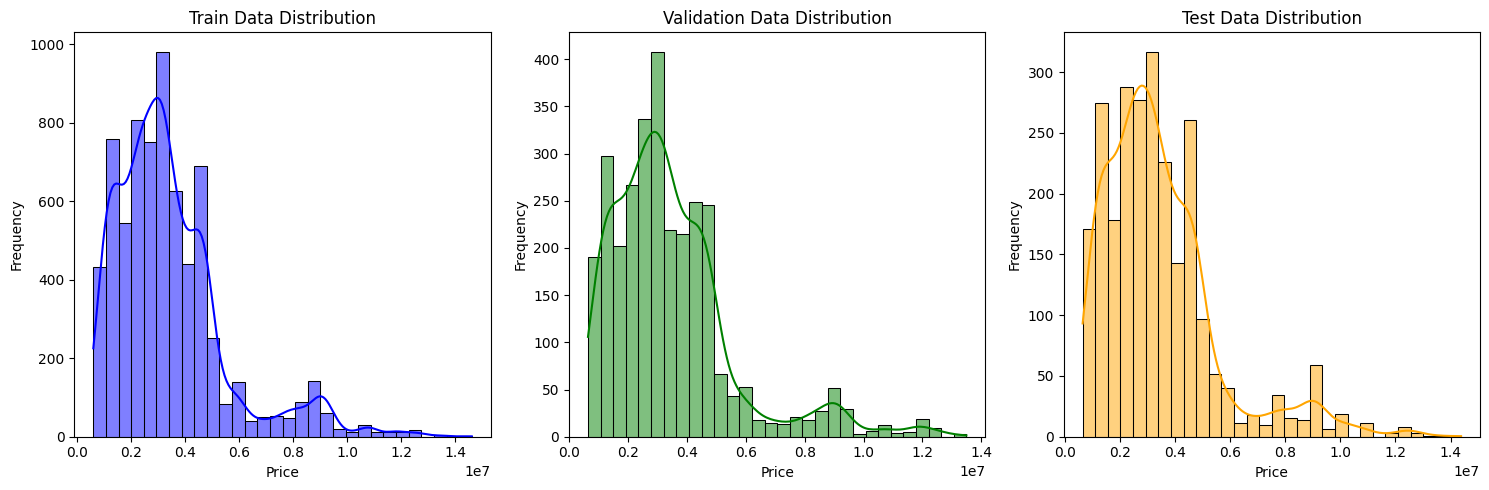

In [4]:
# Plot data distribution for train, validation, and test sets
plt.figure(figsize=(15, 5))

# Train data distribution
plt.subplot(1, 3, 1)
sns.histplot(y_train, kde=True, color='blue', bins=30)
plt.title('Train Data Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Validation data distribution
plt.subplot(1, 3, 2)
sns.histplot(y_val, kde=True, color='green', bins=30)
plt.title('Validation Data Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Test data distribution
plt.subplot(1, 3, 3)
sns.histplot(y_test, kde=True, color='orange', bins=30)
plt.title('Test Data Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Tổng quan, cả ba tập dữ liệu Train – Validation – Test đều chia sẻ đặc điểm “phân phối lệch phải” (right‑skewed) với đa số giá nằm ở khoảng 2–4 triệu, kèm theo một đuôi dài của các giá trị cao bất thường (outlier). Tuy nhiên:

Train: Phân phối dày nhất tại 2–4 triệu, có một ít outlier vượt >10 triệu.

Validation: Đuôi cao giá ngắn hơn, tập trung hơi dịch về giá thấp (1.5–3 triệu), giúp kiểm tra tính ổn định của model ở vùng giá trung bình.

Test: Vẫn giữ đỉnh tại 2–4 triệu, nhưng xuất hiện thêm “gù” nhỏ quanh 0.5–1 triệu và một số outlier lên ~14 triệu, cho thấy model cần đủ linh hoạt để dự đoán tốt cả ở vùng giá rất thấp và rất cao.

### Hàm plot kết quả 

In [5]:
def plot(predictions, y_test):
    sns.histplot(y_test-predictions)
    
    fig1, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.plot([i for i in range(250)], y_test[0:250],  color='blue')
    ax.plot([i for i in range(250)], predictions[0:250], color='orange')

    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])

    fig1.show()
    
    fig2, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.scatter([i for i in range(250)], y_test[0:250],  color='blue', linewidths=4)
    ax.scatter([i for i in range(250)], predictions[0:250], color='orange', linewidths=3)
    
    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])
    
    fig2.show()

### Sử dụng 3 metrics: MAE, RMSE và MAPE để nhanh chóng đánh giá sơ bộ kết quả của mô hình

In [6]:
def models_score(x_train, x_val, y_train, y_val):    
    models = {
        "RandomForest":RandomForestRegressor(),
         }
    evalutes = {}
    i = 0
    maes = []
    rmse = []
    mape = []
    names = []
    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred=model.predict(x_val) 
        names.append(name)
        maes.append(mean_absolute_error(y_val,y_pred))
        rmse.append(math.sqrt(mean_squared_error(y_val,y_pred)))
        mape.append(mean_absolute_percentage_error(y_val, y_pred))
    evalutes = {'Algorithms': names, 'MAE': maes, 'RMSE': rmse, "MAPE":mape}
    model_scores = pd.DataFrame(evalutes)
    return model_scores

## Feature Extraction

### Khảo sát hiệu suất mô hình trước khi thực hiện trích xuất đặc trưng

In [7]:
score = models_score(X_train_scaled, X_val_scaled, y_train, y_val)
score

,Algorithms,MAE,RMSE,MAPE
0,RandomForest,337855.062307,530366.967286,0.119529


### Nhận xét:
Mô hình Random Forest đang có hiệu suất ổn với mức MAPE là 12% (khá tốt trên một tập dữ liệu lớn)

Tuy nhiên, RMSE cao hơn MAE cho thấy mô hình có vài điểm dự đoán lệch lớn → có thể cải thiện bằng cách xử lý ngoại lệ hoặc tinh chỉnh mô hình.

## Lựa chọn đặc trưng

In [8]:
df.reset_index(inplace=True, drop=True)
df_X = data.drop('Price', axis = 1)
df_Y = data['Price']

In [9]:
def feature_importance(ml_model):
    print('Model: {}'.format(ml_model))
    model = ml_model.fit(df_X, df_Y)
    plt.figure(figsize=(15,10))
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending = True)
    feat_importances.plot(kind='barh')
    plt.show()

Model: RandomForestRegressor(random_state=42)


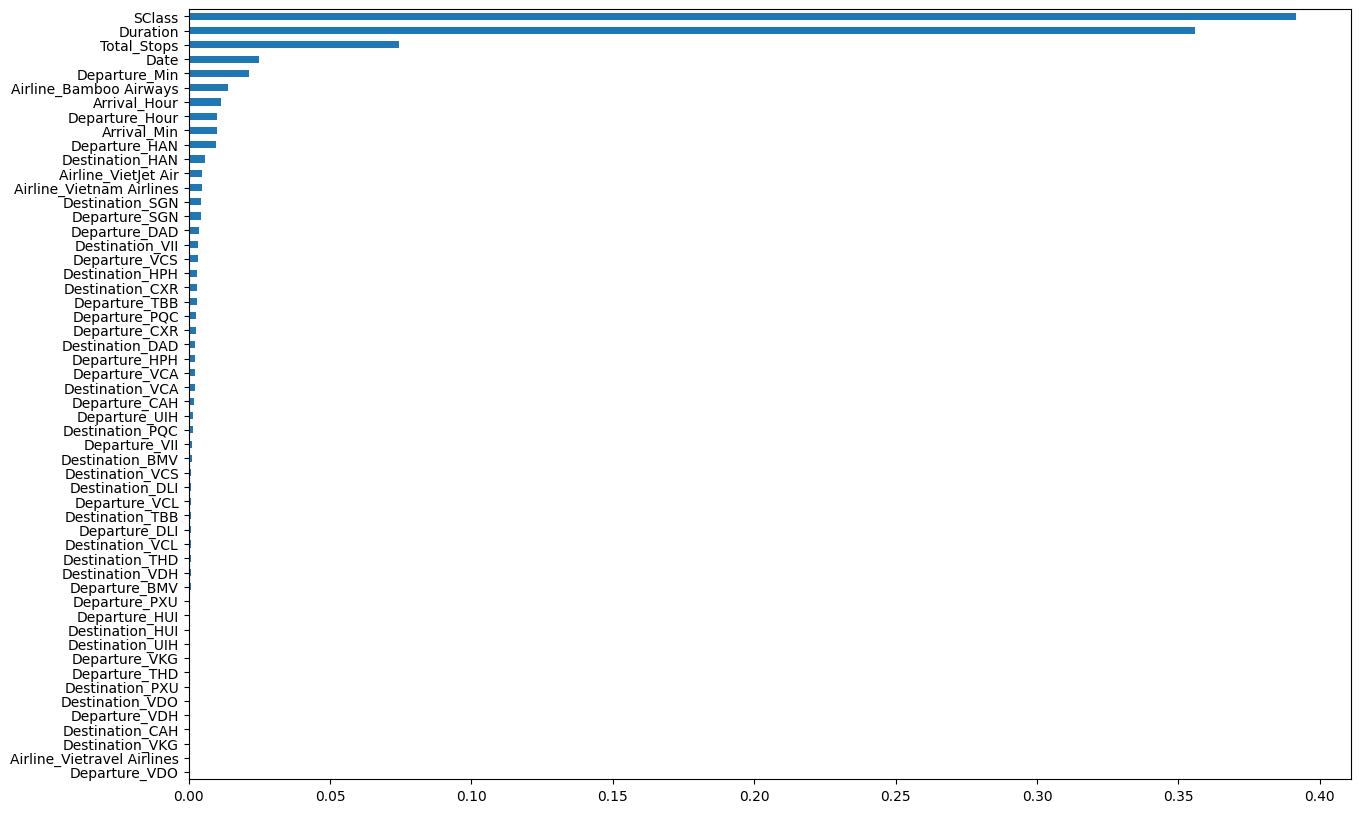

In [10]:
rf = RandomForestRegressor(random_state=42)
feature_importance(rf)

Feature: 0, Score: 0.34850
Feature: 1, Score: 0.02340
Feature: 2, Score: 0.07644
Feature: 3, Score: 0.39572
Feature: 4, Score: 0.01062
Feature: 5, Score: 0.02123
Feature: 6, Score: 0.01110
Feature: 7, Score: 0.01131
Feature: 8, Score: 0.01495
Feature: 9, Score: 0.00498
Feature: 10, Score: 0.00649
Feature: 11, Score: 0.00007
Feature: 12, Score: 0.00059
Feature: 13, Score: 0.00204
Feature: 14, Score: 0.00286
Feature: 15, Score: 0.00411
Feature: 16, Score: 0.00095
Feature: 17, Score: 0.00854
Feature: 18, Score: 0.00217
Feature: 19, Score: 0.00062
Feature: 20, Score: 0.00304
Feature: 21, Score: 0.00062
Feature: 22, Score: 0.00429
Feature: 23, Score: 0.00258
Feature: 24, Score: 0.00039
Feature: 25, Score: 0.00112
Feature: 26, Score: 0.00201
Feature: 27, Score: 0.00177
Feature: 28, Score: 0.00287
Feature: 29, Score: 0.00026
Feature: 30, Score: 0.00002
Feature: 31, Score: 0.00132
Feature: 32, Score: 0.00048
Feature: 33, Score: 0.00111
Feature: 34, Score: 0.00008
Feature: 35, Score: 0.00286
Fe

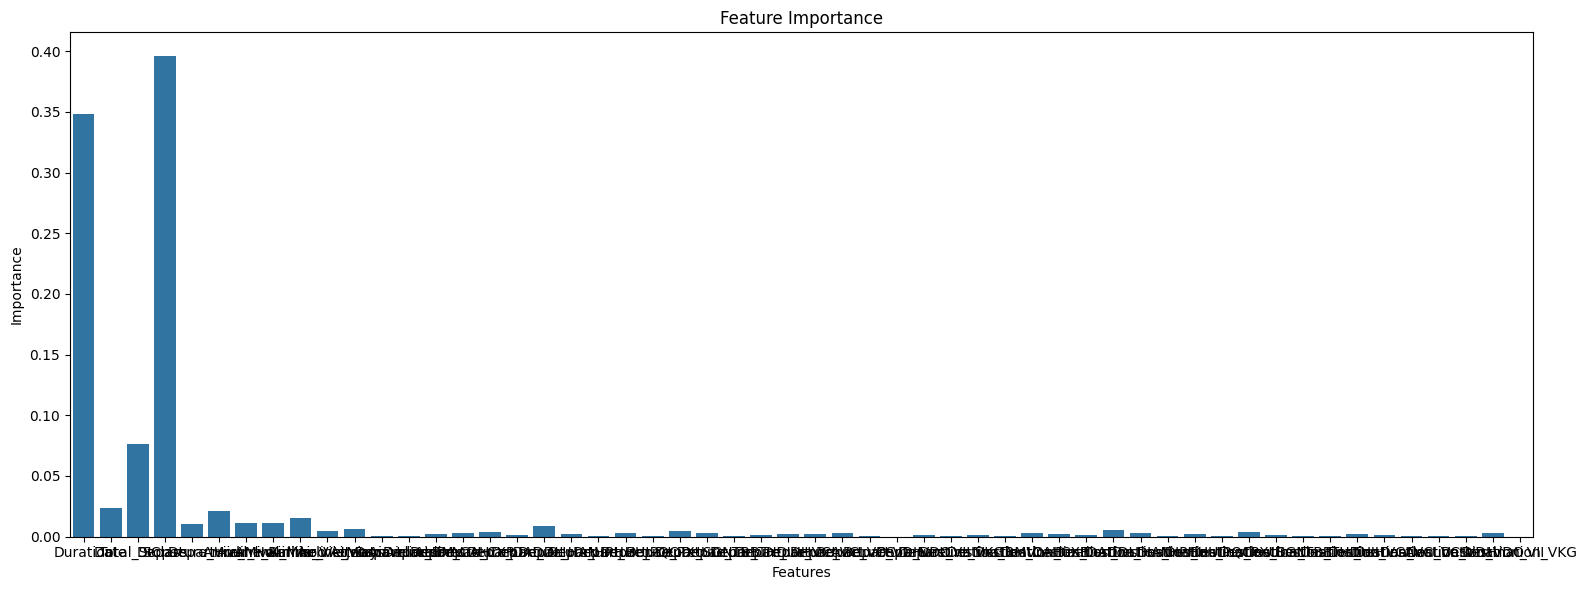

In [11]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.figure(figsize=(16, 6)) 
sns.barplot(x=list(X_train.columns), y=importance)


plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")

plt.tight_layout()
plt.show()

### Từ đây, ta thấy được top 3 feature cho mô hình random forest là: 
 - Duration
 - Total_stop
 - SClass


### Chọn ra những feature quan trọng

In [12]:
X_train_rf = X_train[['SClass', 'Duration', 'Total_Stops']]
X_val_rf = X_val[['SClass', 'Duration', 'Total_Stops']]

In [13]:
rf_score = models_score(X_train_rf, X_val_rf, y_train, y_val)
rf_score

,Algorithms,MAE,RMSE,MAPE
0,RandomForest,669316.188537,926899.877061,0.22525


## Xây dựng các class mô hình cho việc dự đoán và trình bày kết quả

In [14]:
class Model:
    def __init__(self):
        pass

    def predict(self, X_val):
        self.y_pred = self.model.predict(X_val)
        return self.y_pred
    
    
    # dùng để đánh giá mô hình trên metrics thông qua 4 metrics: MAE, RMSE, MAPE, R2 score
    def evaluate(self, y_true):
        self.score_mae = mean_absolute_error(y_true, self.y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, self.y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, self.y_pred)
        self.r2 = r2_score(y_true, self.y_pred)
        
        print(Fore.GREEN + 'MAE: {}'.format(self.score_mae))
        print(Fore.GREEN + 'RMSE: {}'.format(self.score_rmse))
        print(Fore.GREEN + 'MAPE: {}'.format(self.score_mape))
        print(Fore.GREEN + 'R2: {}'.format(self.r2))
        
        return self.score_mae, self.score_rmse, self.score_mape, self.r2


    def plot_yy(self, width, height, y_pred, y_val):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_val, y_pred, color='red')
        plt.plot(y_val, y_val)
        plt.grid()
        plt.xlabel('Actual price (Thousand VND)')
        plt.ylabel('Predicted price (Thousand VND)')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()

class ModelRandomForest(Model):
    def __init__(self, model, search=False):
        self.model = model
        self.search = search
        self.params = {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [None, 10, 20],
                        'min_samples_split': [1, 2, 4],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': [None, 1, 2],
                        'bootstrap': [True, False]
                    }
    def train(self, X_train, y_train):
        if not self.search:
            self.model.fit(X_train, y_train)
        else:
            grid_search = GridSearchCV(estimator=self.model, param_grid=self.params, cv=5, n_jobs=-1, verbose=3, scoring="r2")
            grid_search.fit(X_train, y_train)
            self.params = grid_search.best_params_
            self.model = RandomForestRegressor(**self.params)
            self.model.fit(X_train, y_train)
            print(grid_search.scorer_)

### Kết quả của Random Forest

MAE: 337014.01251446083
RMSE: 526615.4076860462
MAPE: 0.11903989847409299
R2: 0.9394789720379976


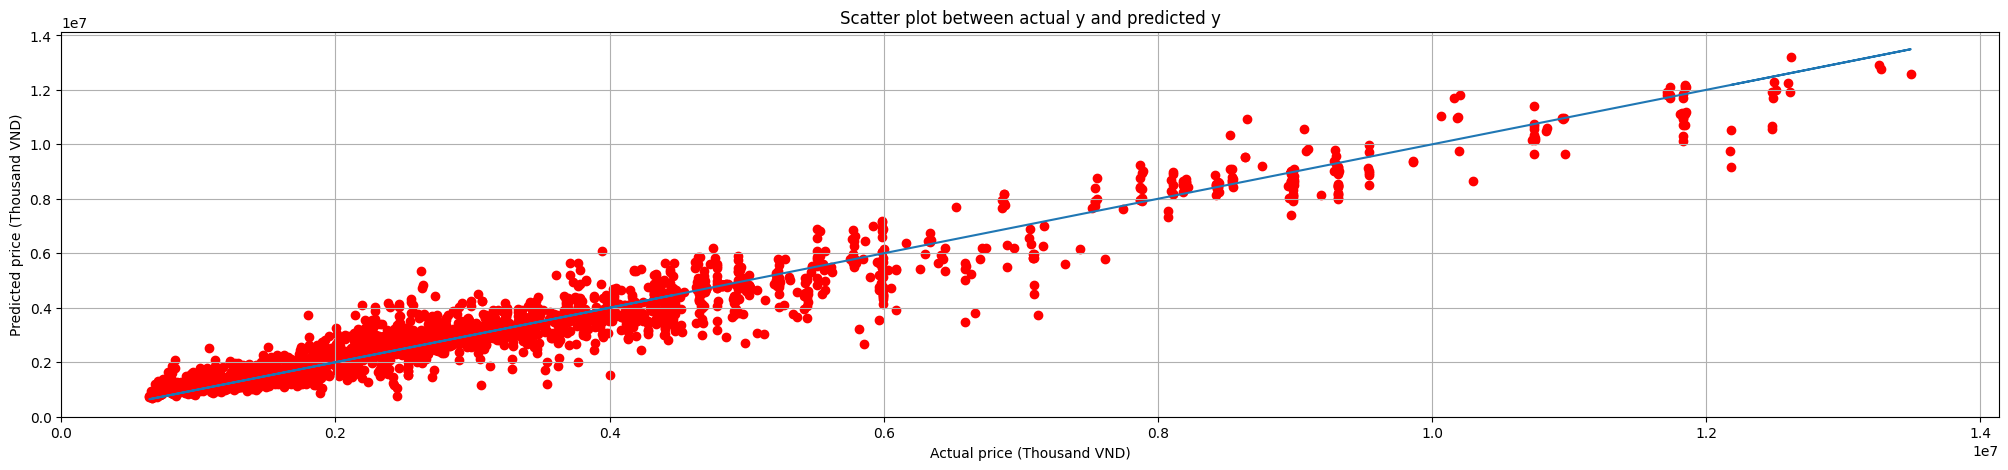

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
rdf = ModelRandomForest(model = RandomForestRegressor())
rdf.train(X_train, y_train)
rdf_y_pred = rdf.predict(X_val)
c = rdf.evaluate(y_val)
rdf.plot_yy(25, 5, rdf_y_pred, y_val)
print(rdf.model.get_params())

In [26]:
def plot(predictions, y_test):
    sns.histplot(y_test-predictions)
    
    fig1, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.plot([i for i in range(250)], y_test[0:250],  color='blue')
    ax.plot([i for i in range(250)], predictions[0:250], color='orange')

    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])

    fig1.show()
    
    fig2, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.scatter([i for i in range(250)], y_test[0:250],  color='blue', linewidths=4)
    ax.scatter([i for i in range(250)], predictions[0:250], color='orange', linewidths=3)
    
    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])
    
    fig2.show()

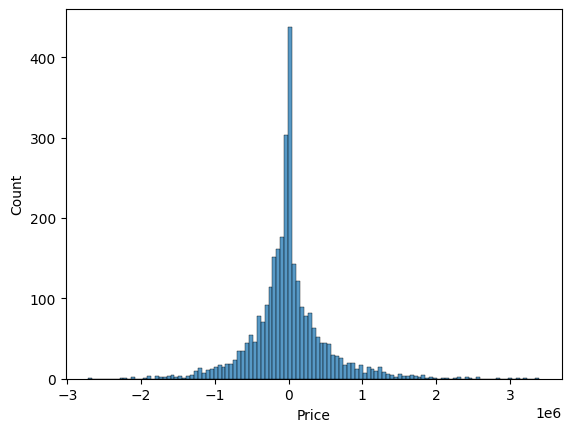

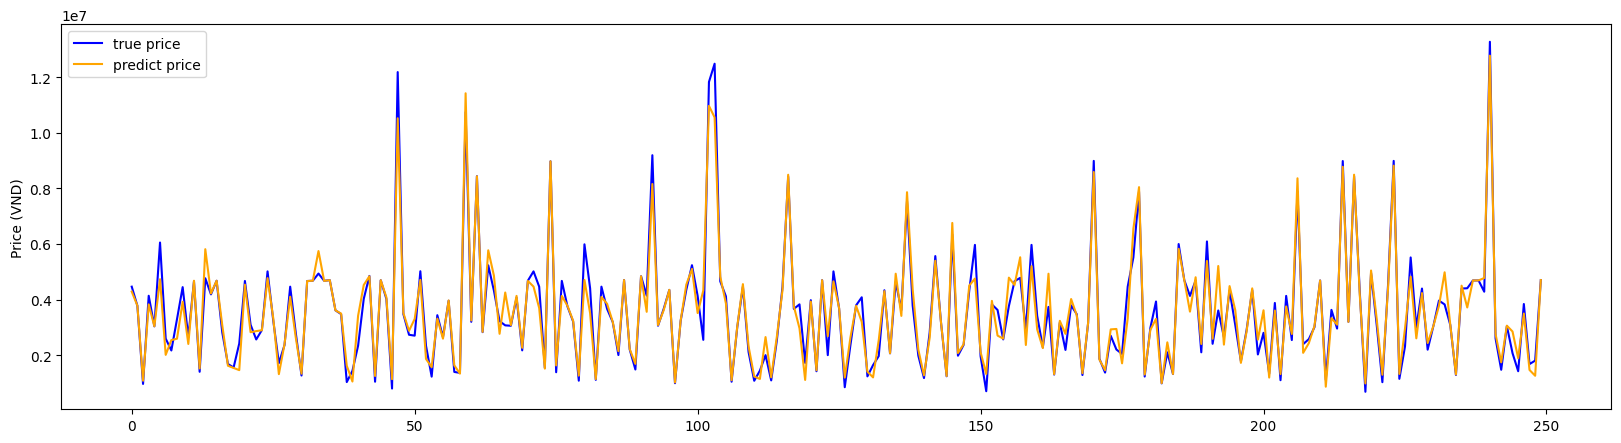

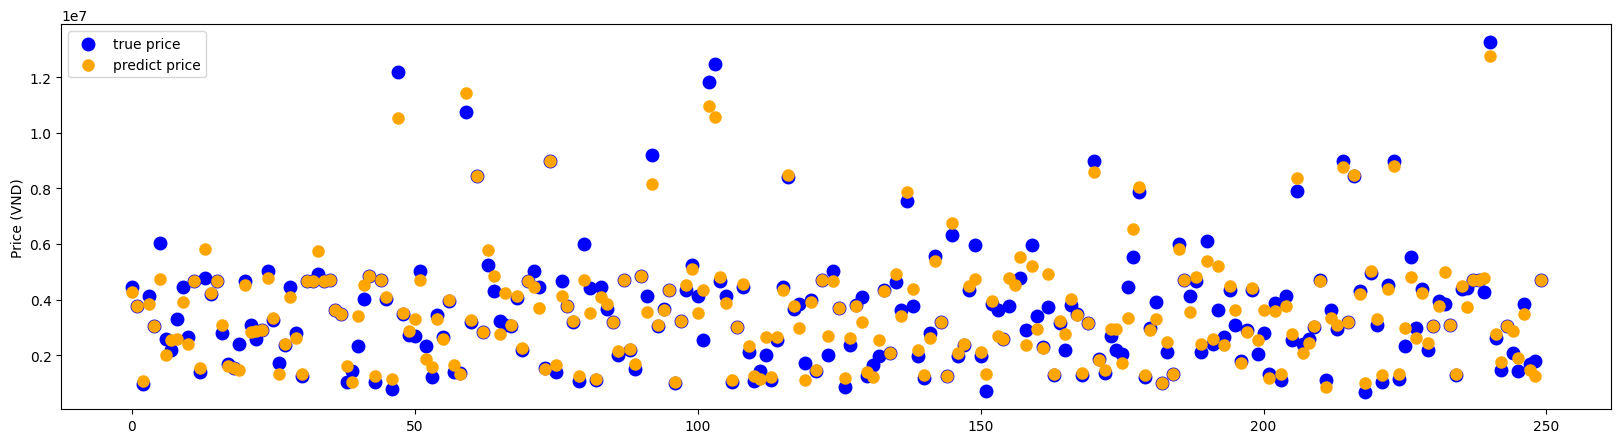

In [27]:
plot(rdf_y_pred, y_val)

### Nhận xét:
1. Mối tương quan tuyến tính khá mạnh

– Hầu hết các điểm tập trung quanh đường y = x, minh chứng cho khả năng “nắm bắt” xu hướng chung của Random Forest.
– Điều này nhất quán với giá trị MAPE ~ 12%, tức trung bình sai số chỉ khoảng 12% so với giá thực.

2. Độ lan rộng sai số (variance) có xu hướng tăng với giá trị thực

– Ở vùng giá thấp (dưới ~ 4 triệu), các điểm rất khít quanh đường, sai số nhỏ.

– Khi giá thực tăng (từ 6–10 triệu trở lên), các điểm phân tán rộng hơn, nghĩa là mô hình có nhiều outlier (“dự đoán lệch”) ở mức giá cao.

3. Một số xu hướng bias nhẹ ở vùng giá cao

– Có khuynh hướng dự đoán thấp hơn thực tế (underestimation) cho những ngôi nhà đắt tiền nhất (trên ~ 12 triệu).

– Ngược lại, với một vài trường hợp ở tầm trung, mô hình cũng thổi phồng giá (overestimation), nhưng ít phổ biến hơn.

4. Outliers và ngoại lệ
– Một số điểm nằm khá xa đường y = x, thể hiện những tình huống mô hình “bất ngờ” sai lớn.

– Có thể do:

        Dữ liệu huấn luyện thiếu ví dụ ở mức giá rất cao hoặc rất thấp.
        
        Thiếu các biến giải thích đặc thù

In [16]:
print(rdf.model.score(X_train, y_train))
print(rdf.model.score(X_val, y_val))

0.9899615202083498
0.9394789720379976


### Nhận xét chung
Chênh lệch train vs. val (~0.99 vs. ~0.94)

Có dấu hiệu overfitting nhẹ: mô hình học hơi “kĩ” trên train, nên khi chạy trên dữ liệu mới accuracy giảm một chút.

Tuy nhiên gap ~0.05 là hoàn toàn chấp nhận được với Random Forest, nhất là khi dữ liệu có độ phức tạp và nhiễu cao.

Validation R² ~0.94

Một con số ấn tượng, ngụ ý mô hình dự đoán rất sát thực tế (thừa hưởng cả MAPE ~12% và MAE/RMSE phía trước).


In [17]:
from tabulate import tabulate

def compute_metrics(y_true, y_pred):
    n = len(y_true)
    errors = y_pred - y_true
    mae = np.sum(np.abs(errors)) / n
    mse = np.sum(errors**2) / n
    rmse = np.sqrt(mse)
    return mae, mse, rmse

def train_random_forest(X_train, y_train, X_val, y_val,
                        n_estimators=100, max_depth=None, random_state=0):
    """
    Huấn luyện RandomForestRegressor và in metrics.
    Trả về model đã train.
    """
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    
    # Dự đoán trên train & val
    y_train_pred = model.predict(X_train)
    # y_val_pred  = model.predict(X_val)
    
    # Tính metrics
    tr_mae, tr_mse, tr_rmse = compute_metrics(y_train, y_train_pred)
    # te_mae, te_mse, te_rmse = compute_metrics(y_val, y_val_pred)
    
    print(f"RandomForest (n_estimators={n_estimators}, max_depth={max_depth})")
    print(f" Train MAE={tr_mae:.2f}, MSE={tr_mse:.2f}, RMSE={tr_rmse:.2f}")
    # print(f" val  MAE={te_mae:.2f}, MSE={te_mse:.2f}, RMSE={te_rmse:.2f}")
    
    return model

def predict(ml_model, x_train, x_val):
    print('Model: {}'.format(ml_model))
    table = []
    headers = ['Metrics', 'Values']
    
    model = ml_model.fit(x_train, y_train)
    
    training_score = model.score(x_train, y_train)
    valing_score = model.score(x_val, y_val)
    table.append(['Training score', training_score])
    table.append(['valing score', valing_score])
    
    predictions = model.predict(x_val)
    
    MAE = mean_absolute_error(y_val, predictions)
    MSE = mean_squared_error(y_val, predictions)
    RMSE = np.sqrt(MSE)
    
    table.append(['MAE', MAE]) 
    table.append(['MSE', MSE]) 
    table.append(['RMSE', RMSE])
    
    print(tabulate(table, headers=headers, tablefmt='fancy_grid', numalign='right', floatfmt=".2f"))
    
    return predictions, training_score, valing_score, MAE, MSE, RMSE

# Ví dụ sử dụng:
# rf = train_random_forest(X_train, y_train, X_val, y_val,
#                          n_estimators=200, max_depth=10)
# y_pred = predict(rf, X_val)


In [18]:
def plot_val(predictions):
    # Use the validation data since predict() uses X_val
    sns.distplot(y_val-predictions)
    
    # Ensure we're only plotting the available data
    n_samples = min(250, len(y_val), len(predictions))
    
    fig1, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.plot([i for i in range(n_samples)], y_val[0:n_samples],  color='blue')
    ax.plot([i for i in range(n_samples)], predictions[0:n_samples], color='orange')

    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])

    fig1.show()
    
    fig2, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.scatter([i for i in range(n_samples)], y_val[0:n_samples],  color='blue', linewidths=4)
    ax.scatter([i for i in range(n_samples)], predictions[0:n_samples], color='orange', linewidths=3)
    
    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])
    
    fig2.show()

Model: RandomForestRegressor(random_state=42)
╒════════════════╤═════════════════╕
│ Metrics        │          Values │
╞════════════════╪═════════════════╡
│ Training score │            0.99 │
├────────────────┼─────────────────┤
│ valing score   │            0.94 │
├────────────────┼─────────────────┤
│ MAE            │       338151.66 │
├────────────────┼─────────────────┤
│ MSE            │ 277788249587.99 │
├────────────────┼─────────────────┤
│ RMSE           │       527056.21 │
╘════════════════╧═════════════════╛


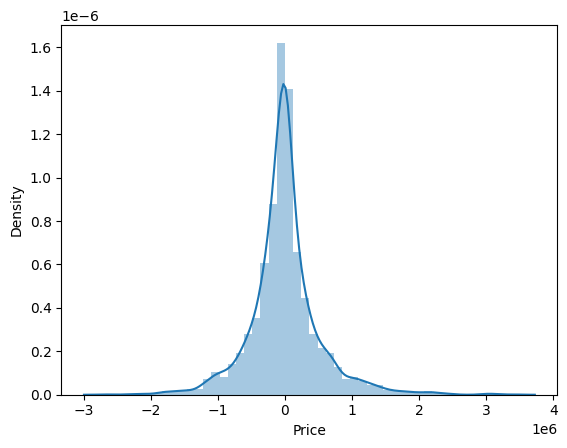

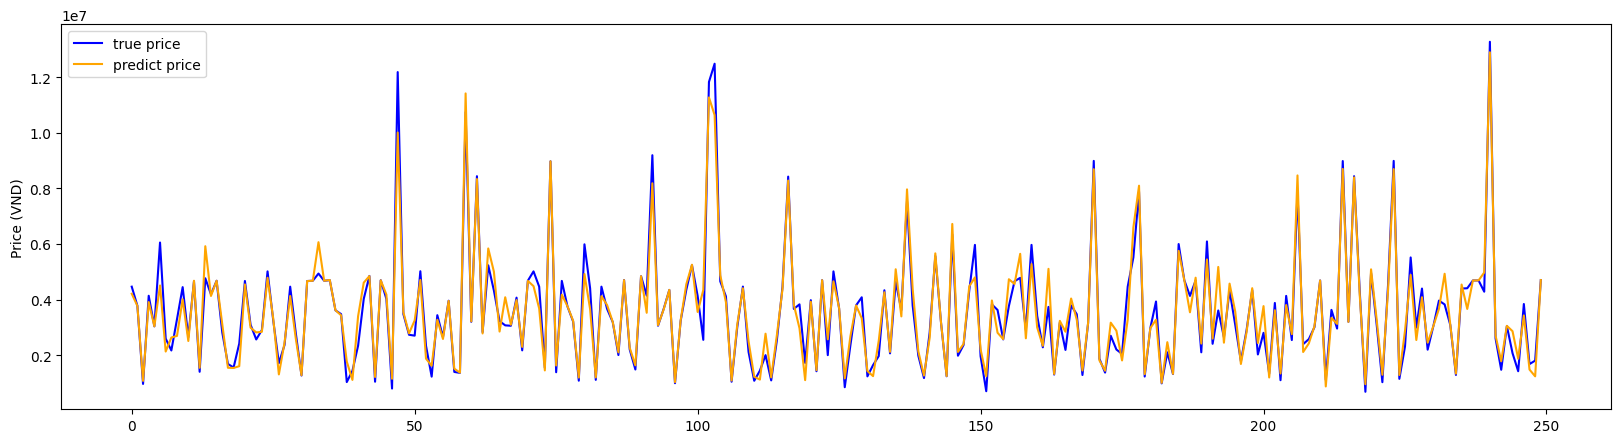

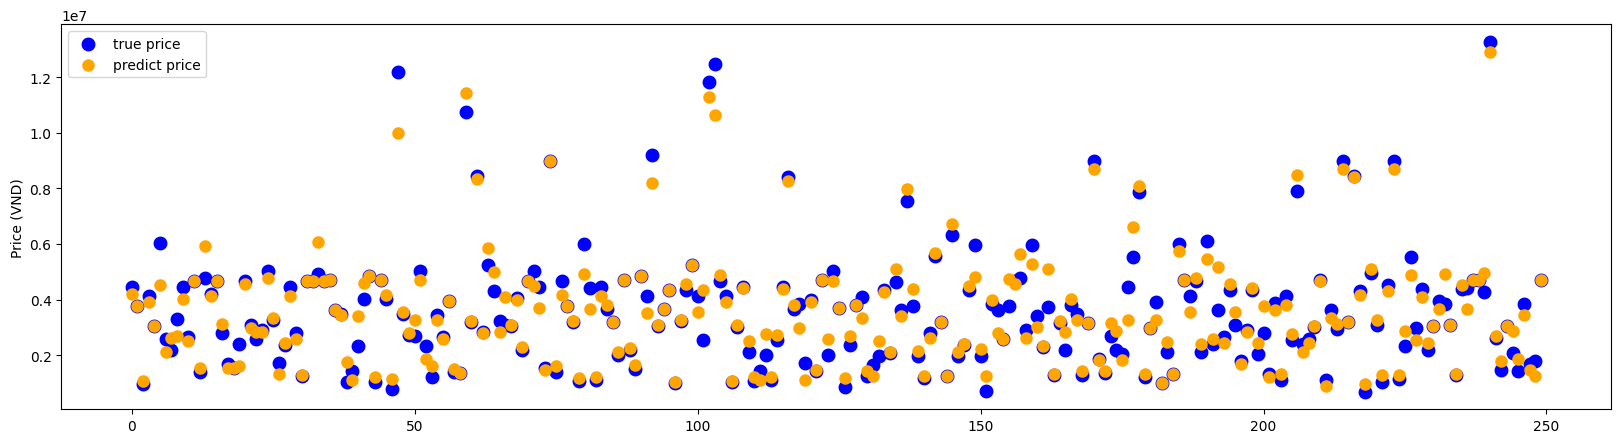

In [19]:
predictions_rf, training_score_rf, testing_score_rf, MAE_rf, MSE_rf, RMSE_rf = predict(rf, X_train, X_val)
plot_val(predictions_rf)

Model: RandomForestRegressor(random_state=42)
╒════════════════╤═════════════════╕
│ Metrics        │          Values │
╞════════════════╪═════════════════╡
│ Training score │            0.83 │
├────────────────┼─────────────────┤
│ valing score   │            0.81 │
├────────────────┼─────────────────┤
│ MAE            │       669693.75 │
├────────────────┼─────────────────┤
│ MSE            │ 857881718451.09 │
├────────────────┼─────────────────┤
│ RMSE           │       926219.04 │
╘════════════════╧═════════════════╛


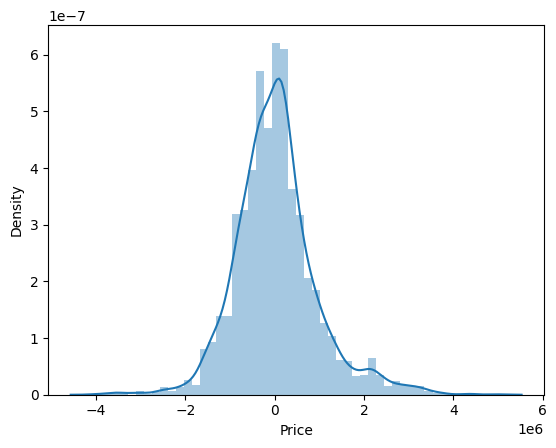

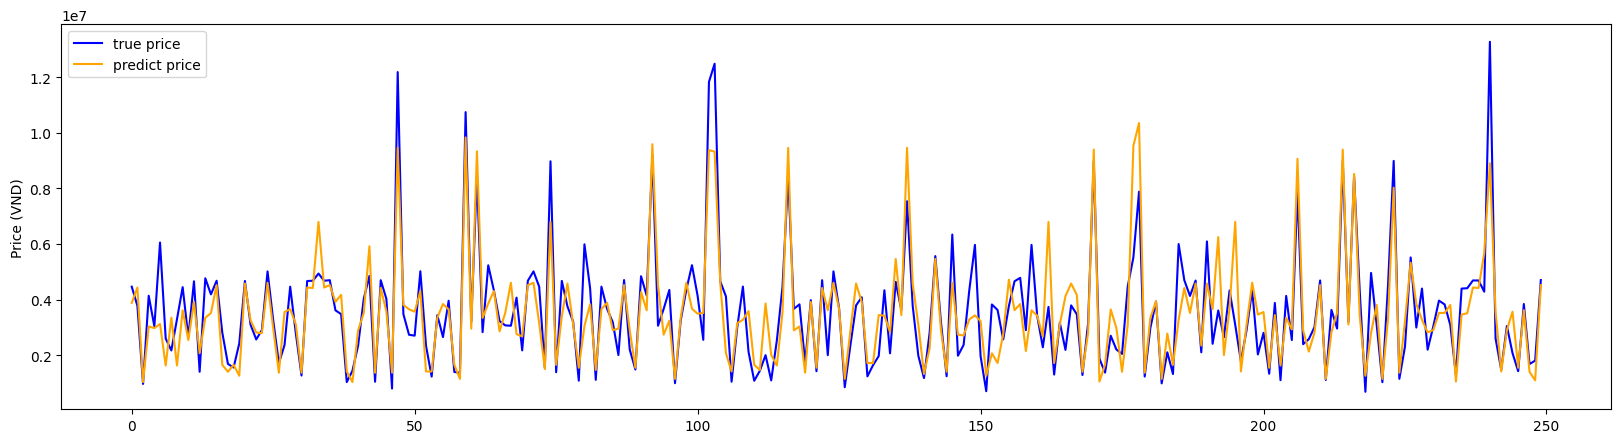

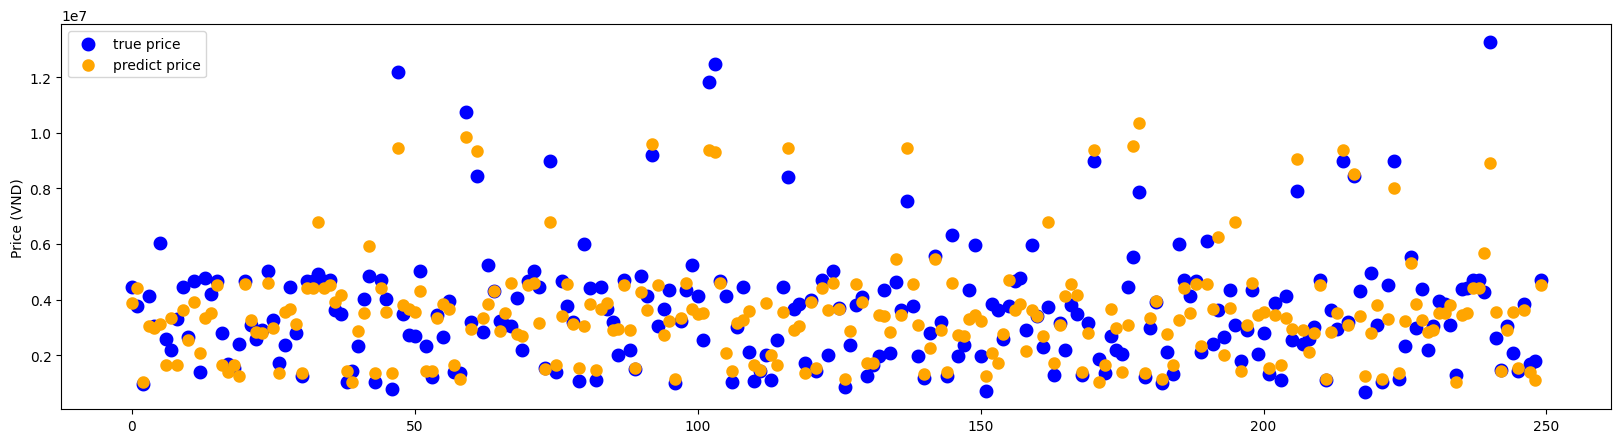

In [20]:
x_train_rf = X_train[['SClass', 'Duration', 'Total_Stops']]
x_val_rf = X_val[['SClass', 'Duration', 'Total_Stops']]

predictions_rf_fs, training_score_rf_fs, valing_score_rf_fs, MAE_rf_fs, MSE_rf_fs, RMSE_rf_fs = predict(rf, x_train_rf, x_val_rf)
plot_val(predictions_rf_fs)

In [31]:
print('Model: {}'.format(rf))
table_rf = []
table_rf.append(['', 'Without Feature Selection', 'With Feature Selection'])
table_rf.append(['Training score', training_score_rf, training_score_rf_fs])
table_rf.append(['Evaluation score', testing_score_rf, valing_score_rf_fs])
table_rf.append(['MAE', MAE_rf, MAE_rf_fs])
table_rf.append(['MSE', MSE_rf, MSE_rf_fs])
table_rf.append(['RMSE', RMSE_rf, RMSE_rf_fs])
print(tabulate(table_rf, headers='firstrow', tablefmt='fancy_grid', numalign='right', floatfmt=".2f"))

Model: RandomForestRegressor(random_state=42)
╒══════════════════╤═════════════════════════════╤══════════════════════════╕
│                  │   Without Feature Selection │   With Feature Selection │
╞══════════════════╪═════════════════════════════╪══════════════════════════╡
│ Training score   │                        0.99 │                     0.83 │
├──────────────────┼─────────────────────────────┼──────────────────────────┤
│ Evaluation score │                        0.94 │                     0.81 │
├──────────────────┼─────────────────────────────┼──────────────────────────┤
│ MAE              │                   338151.66 │                669693.75 │
├──────────────────┼─────────────────────────────┼──────────────────────────┤
│ MSE              │             277788249587.99 │          857881718451.09 │
├──────────────────┼─────────────────────────────┼──────────────────────────┤
│ RMSE             │                   527056.21 │                926219.04 │
╘═════════════════

In [42]:
param_grid_rf = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_hyperparams_rf = grid_search.best_params_

print('Best hyperparameters for model {}: {}'.format(rf, best_hyperparams_rf))


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best hyperparameters for model RandomForestRegressor(random_state=42): {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


Model: RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=1000,
                      random_state=42)
╒════════════════╤═════════════════╕
│ Metrics        │          Values │
╞════════════════╪═════════════════╡
│ Training score │            0.94 │
├────────────────┼─────────────────┤
│ valing score   │            0.90 │
├────────────────┼─────────────────┤
│ MAE            │       507371.63 │
├────────────────┼─────────────────┤
│ MSE            │ 459483811199.97 │
├────────────────┼─────────────────┤
│ RMSE           │       677852.35 │
╘════════════════╧═════════════════╛


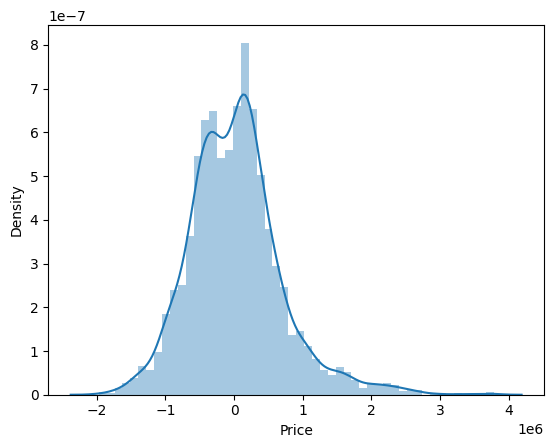

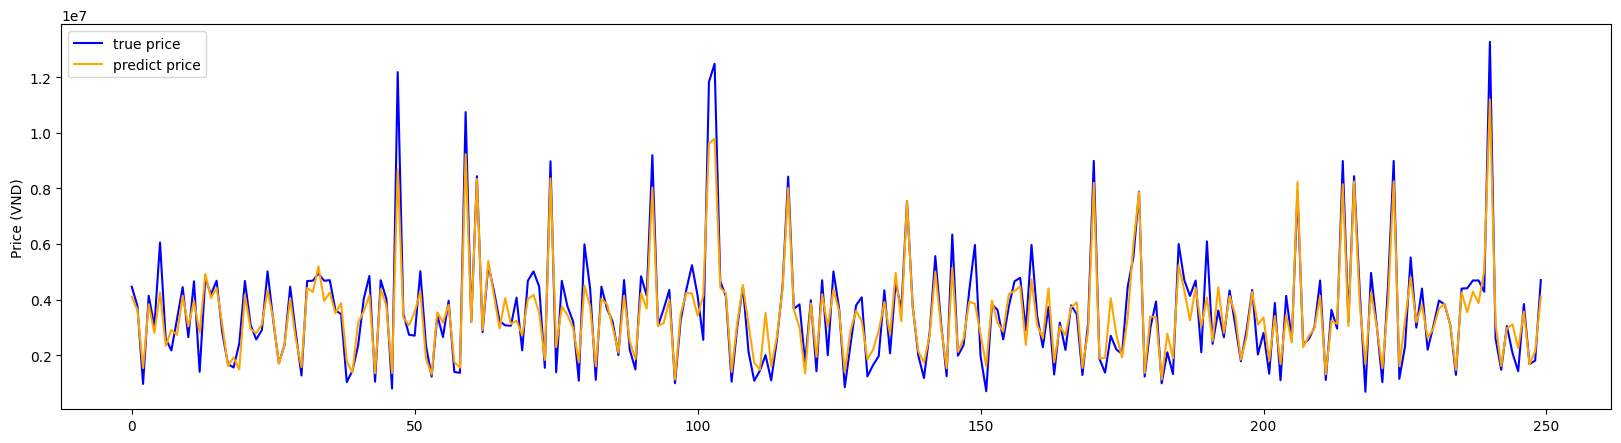

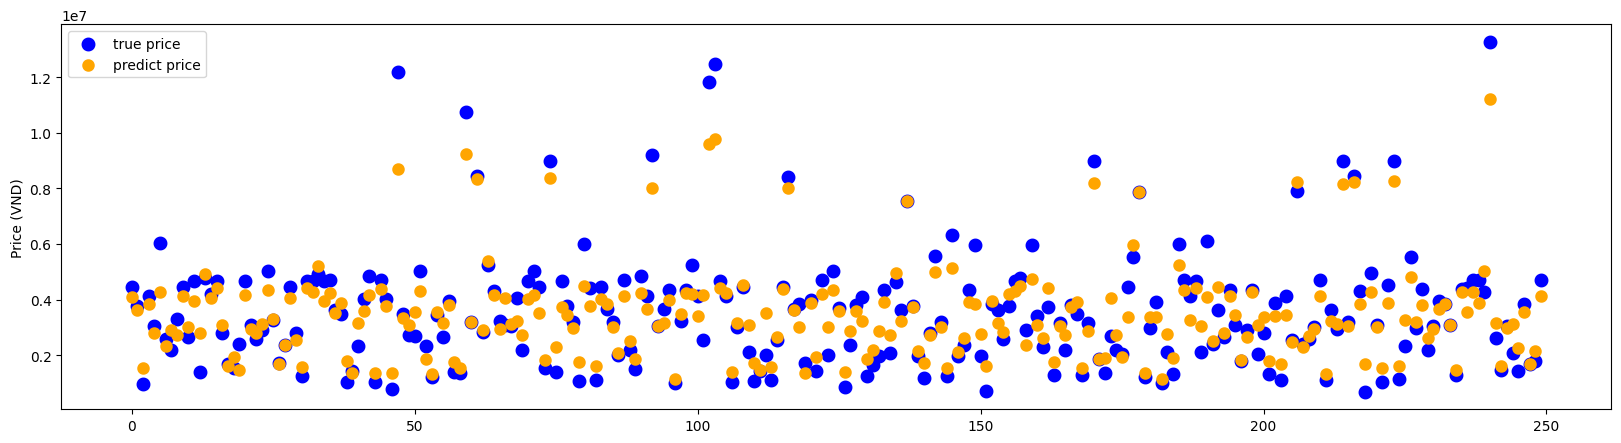

In [43]:
rf_hyper = RandomForestRegressor(**best_hyperparams_rf, random_state=42)
predictions_rf_hyper, training_score_rf_hyper, testing_score_rf_hyper, MAE_rf_hyper, MSE_rf_hyper, RMSE_rf_hyper = predict(rf_hyper, X_train, X_val)
plot_val(predictions_rf_hyper)

Model: RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=1000,
                      random_state=42)
╒════════════════╤═════════════════╕
│ Metrics        │          Values │
╞════════════════╪═════════════════╡
│ Training score │            0.83 │
├────────────────┼─────────────────┤
│ valing score   │            0.81 │
├────────────────┼─────────────────┤
│ MAE            │       668726.12 │
├────────────────┼─────────────────┤
│ MSE            │ 856108116085.13 │
├────────────────┼─────────────────┤
│ RMSE           │       925261.11 │
╘════════════════╧═════════════════╛


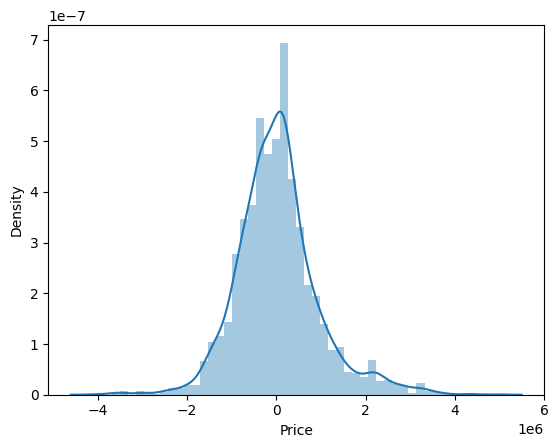

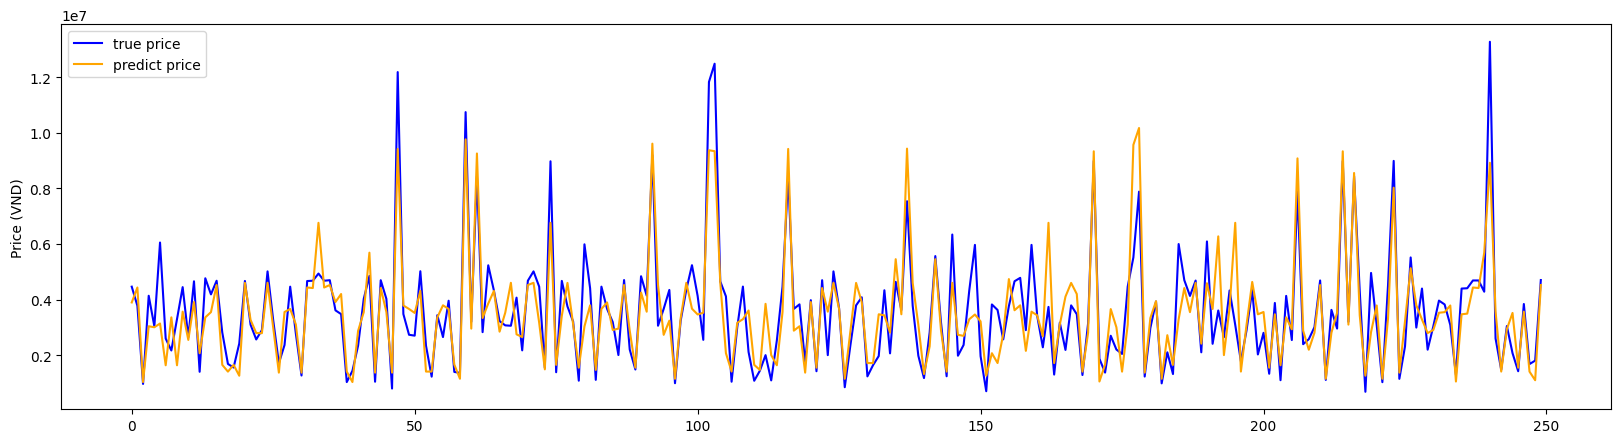

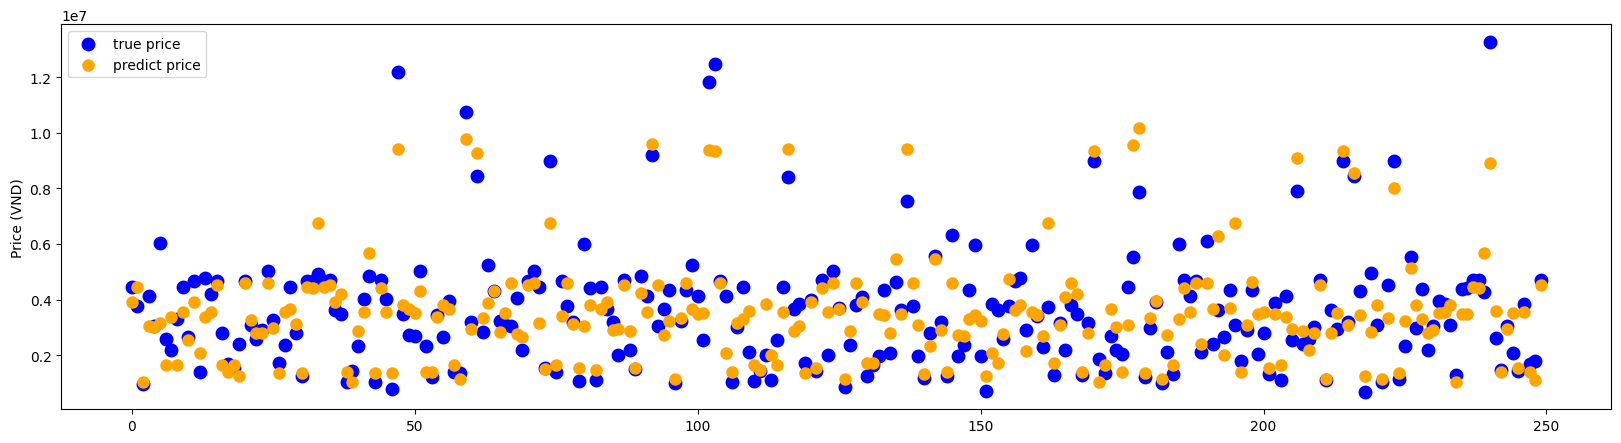

In [44]:
rf_hyper = RandomForestRegressor(**best_hyperparams_rf, random_state=42)
predictions_rf_hyper_fs, training_score_rf_hyper_fs, valing_score_rf_hyper_fs, MAE_rf_hyper_fs, MSE_rf_hyper_fs, RMSE_rf_hyper_fs = predict(rf_hyper, X_train_rf, X_val_rf)
plot_val(predictions_rf_hyper_fs)

In [46]:
print('Model: {}'.format(rf))
table_rf = []
table_rf.append(['', 'Finetuning hyperparam all features', 'Fine Tuning Hyperparam selected features'])
table_rf.append(['Training score', training_score_rf_hyper, training_score_rf_hyper_fs])
table_rf.append(['Evaluation score', testing_score_rf_hyper, valing_score_rf_hyper_fs])
table_rf.append(['MAE', MAE_rf_hyper, MAE_rf_hyper_fs])
table_rf.append(['MSE', MSE_rf_hyper, MSE_rf_hyper_fs])
table_rf.append(['RMSE', RMSE_rf_hyper, RMSE_rf_hyper_fs])
print(tabulate(table_rf, headers='firstrow', tablefmt='fancy_grid', numalign='right', floatfmt=".2f"))

Model: RandomForestRegressor(random_state=42)
╒══════════════════╤══════════════════════════════════════╤════════════════════════════════════════════╕
│                  │   Finetuning hyperparam all features │   Fine Tuning Hyperparam selected features │
╞══════════════════╪══════════════════════════════════════╪════════════════════════════════════════════╡
│ Training score   │                                 0.94 │                                       0.83 │
├──────────────────┼──────────────────────────────────────┼────────────────────────────────────────────┤
│ Evaluation score │                                 0.90 │                                       0.81 │
├──────────────────┼──────────────────────────────────────┼────────────────────────────────────────────┤
│ MAE              │                            507371.63 │                                  668726.12 │
├──────────────────┼──────────────────────────────────────┼────────────────────────────────────────────┤
│ MSE    

## Triển khai mô hình trên Test data

### Thực hiện feature engineering trên data test

In [47]:
X_test = testset.drop(["Price"] , axis=1)
selected_features = ['SClass', 'Duration', 'Total_Stops']
X_test_rf = X_test[selected_features]
y_test_rf = testset["Price"]
X_test_rf = X_test_rf.reset_index(drop=True)
y_test_rf = y_test.reset_index(drop=True)

### Random Forest

Default model

In [53]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# plot(y_pred)

In [57]:
from tabulate import tabulate

test_r2  = rf.score(X_test, y_test)

# Compute error metrics on the test set
mae   = mean_absolute_error(y_test, y_pred)
mse   = mean_squared_error(y_test, y_pred)
rmse  = np.sqrt(mse)
r2    = r2_score(y_test, y_pred)

print(f"Test R²:  {test_r2:.3f}")
print(f"MAE:       {mae:.3f}")
print(f"MSE:       {mse:.3f}")
print(f"RMSE:      {rmse:.3f}")
print(f"R² (alt):  {r2:.3f}")
# Create a table for metrics
metrics_table = [
    ["Metric", "Value"],
    ["Test R²", f"{test_r2:.3f}"],
    ["MAE", f"{mae:.3f}"],
    ["MSE", f"{mse:.3f}"],
    ["RMSE", f"{rmse:.3f}"],
    ["R² (alt)", f"{r2:.3f}"]
]

# Print the table
print(tabulate(metrics_table, headers="firstrow", tablefmt="fancy_grid", numalign ='right', floatfmt=".3f"))

Test R²:  0.933
MAE:       352839.141
MSE:       297979645609.979
RMSE:      545875.119
R² (alt):  0.933
╒══════════╤══════════════════╕
│ Metric   │            Value │
╞══════════╪══════════════════╡
│ Test R²  │            0.933 │
├──────────┼──────────────────┤
│ MAE      │       352839.141 │
├──────────┼──────────────────┤
│ MSE      │ 297979645609.979 │
├──────────┼──────────────────┤
│ RMSE     │       545875.119 │
├──────────┼──────────────────┤
│ R² (alt) │            0.933 │
╘══════════╧══════════════════╛


Default model with selected feature

In [59]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_rf, y_train)
y_pred_rf = rf.predict(X_test_rf)
# plot(y_pred)

In [60]:
test_r2  = rf.score(X_test_rf,  y_test)

# Compute error metrics on the test set
mae   = mean_absolute_error(y_test, y_pred_rf)
mse   = mean_squared_error(y_test, y_pred_rf)
rmse  = np.sqrt(mse)
r2    = r2_score(y_test, y_pred_rf)

print(f"Test R²:  {test_r2:.3f}")
print(f"MAE:       {mae:.3f}")
print(f"MSE:       {mse:.3f}")
print(f"RMSE:      {rmse:.3f}")
print(f"R² (alt):  {r2:.3f}")
metrics_table = [
    ["Metric", "Value"],
    ["Test R²", f"{test_r2:.3f}"],
    ["MAE", f"{mae:.3f}"],
    ["MSE", f"{mse:.3f}"],
    ["RMSE", f"{rmse:.3f}"],
    ["R² (alt)", f"{r2:.3f}"]
]

# Print the table
print(tabulate(metrics_table, headers="firstrow", tablefmt="fancy_grid", numalign ='right', floatfmt=".3f"))

Test R²:  0.819
MAE:       641906.349
MSE:       800472003306.162
RMSE:      894691.010
R² (alt):  0.819
╒══════════╤══════════════════╕
│ Metric   │            Value │
╞══════════╪══════════════════╡
│ Test R²  │            0.819 │
├──────────┼──────────────────┤
│ MAE      │       641906.349 │
├──────────┼──────────────────┤
│ MSE      │ 800472003306.162 │
├──────────┼──────────────────┤
│ RMSE     │       894691.010 │
├──────────┼──────────────────┤
│ R² (alt) │            0.819 │
╘══════════╧══════════════════╛


Optimized model with default feature

In [61]:
rf_tuned = RandomForestRegressor(**best_hyperparams_rf,random_state=42)
rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test)
# plot(y_pred)

In [63]:
test_r2  = rf_tuned.score(X_test,  y_test)

# Compute error metrics on the test set
mae   = mean_absolute_error(y_test, y_pred_rf_tuned)
mse   = mean_squared_error(y_test, y_pred_rf_tuned)
rmse  = np.sqrt(mse)
r2    = r2_score(y_test, y_pred_rf_tuned)

print(f"Test R²:  {test_r2:.3f}")
print(f"MAE:       {mae:.3f}")
print(f"MSE:       {mse:.3f}")
print(f"RMSE:      {rmse:.3f}")
print(f"R² (alt):  {r2:.3f}")
metrics_table = [
    ["Metric", "Value"],
    ["Test R²", f"{test_r2:.3f}"],
    ["MAE", f"{mae:.3f}"],
    ["MSE", f"{mse:.3f}"],
    ["RMSE", f"{rmse:.3f}"],
    ["R² (alt)", f"{r2:.3f}"]
]

# Print the table
print(tabulate(metrics_table, headers="firstrow", tablefmt="fancy_grid", numalign ='right', floatfmt=".3f"))

Test R²:  0.901
MAE:       501271.421
MSE:       439005699141.699
RMSE:      662575.052
R² (alt):  0.901
╒══════════╤══════════════════╕
│ Metric   │            Value │
╞══════════╪══════════════════╡
│ Test R²  │            0.901 │
├──────────┼──────────────────┤
│ MAE      │       501271.421 │
├──────────┼──────────────────┤
│ MSE      │ 439005699141.699 │
├──────────┼──────────────────┤
│ RMSE     │       662575.052 │
├──────────┼──────────────────┤
│ R² (alt) │            0.901 │
╘══════════╧══════════════════╛


Optimized model with selected feature

In [64]:
rf_tuned_s = RandomForestRegressor(**best_hyperparams_rf,random_state=42)
rf_tuned_s.fit(X_train_rf, y_train)
y_pred_rf_tuned_s = rf_tuned_s.predict(X_test_rf)
# plot(y_pred)

In [65]:
test_r2  = rf_tuned_s.score(X_test_rf,  y_test)

# Compute error metrics on the test set
mae   = mean_absolute_error(y_test, y_pred_rf_tuned_s)
mse   = mean_squared_error(y_test, y_pred_rf_tuned_s)
rmse  = np.sqrt(mse)
r2    = r2_score(y_test, y_pred_rf_tuned_s)

print(f"Test R²:  {test_r2:.3f}")
print(f"MAE:       {mae:.3f}")
print(f"MSE:       {mse:.3f}")
print(f"RMSE:      {rmse:.3f}")
print(f"R² (alt):  {r2:.3f}")
metrics_table = [
    ["Metric", "Value"],
    ["Test R²", f"{test_r2:.3f}"],
    ["MAE", f"{mae:.3f}"],
    ["MSE", f"{mse:.3f}"],
    ["RMSE", f"{rmse:.3f}"],
    ["R² (alt)", f"{r2:.3f}"]
]

# Print the table
print(tabulate(metrics_table, headers="firstrow", tablefmt="fancy_grid", numalign ='right', floatfmt=".3f"))

Test R²:  0.819
MAE:       640469.151
MSE:       797297354268.532
RMSE:      892915.088
R² (alt):  0.819
╒══════════╤══════════════════╕
│ Metric   │            Value │
╞══════════╪══════════════════╡
│ Test R²  │            0.819 │
├──────────┼──────────────────┤
│ MAE      │       640469.151 │
├──────────┼──────────────────┤
│ MSE      │ 797297354268.532 │
├──────────┼──────────────────┤
│ RMSE     │       892915.088 │
├──────────┼──────────────────┤
│ R² (alt) │            0.819 │
╘══════════╧══════════════════╛
